In [1]:
import GPUtil

In [4]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [1]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

2024-11-14 09:23:42.710801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 09:23:42.892458: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 09:23:42.942590: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 09:23:43.388442: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
h = get_available_gpus()

2024-11-14 09:23:53.708054: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:0 with 43598 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:21:00.0, compute capability: 8.6
2024-11-14 09:23:53.709987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /device:GPU:1 with 14221 MB memory:  -> device: 1, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6


In [3]:
h

['/device:GPU:0', '/device:GPU:1']

In [1]:
import time

# Get the current timestamp
timestamp = time.time()

# Convert to a human-readable string
readable_time = time.ctime(timestamp)
print(readable_time)

Thu Oct 31 15:24:55 2024


In [1]:
import keras

2024-10-07 09:14:20.809862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 09:14:21.160493: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 09:14:21.261244: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 09:14:22.097228: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model = keras.models.load_model('/scratch/models/3DFP_1002_5_06.keras')

2024-10-07 09:16:29.282489: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43598 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:21:00.0, compute capability: 8.6


In [4]:
model.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 600, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │     1,249,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 32, 600, 3)     │     1,297,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,638,827 (29.14 MB)

 Trainable params: 2,546,147 (9.71 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 5,092,296 (19.43 MB)

AttributeError: 'Functional' object has no attribute 'encoder'

In [1]:
import pandas as pd
import numpy as np

In [25]:
import matplotlib.pyplot as plt

In [7]:
from skimage.restoration import denoise_wavelet
from time import time as ti

In [10]:
TIME_STEPS = 1200
Skips = 100

In [38]:
def RollingStdDevFaster(RawData, SmoothData, RollSize = 25):

    Diffs = RawData - SmoothData
    del RawData, SmoothData
    
    Sqs = Diffs * Diffs
    del Diffs
    
    Sqs = Sqs.tolist() 
    Sqs.extend(np.zeros(RollSize))
    mSqs = np.matrix(Sqs)
    
    for i in range(RollSize):
        Sqs.insert(0, Sqs.pop())
        mSqs = np.concatenate((np.matrix(Sqs),mSqs))
    
    sVect = mSqs.sum(axis=0)
    eVect = (mSqs!=0).sum(axis=0)
    del mSqs, Sqs
    
    VarVect = sVect / eVect
    StdDevs = np.sqrt(VarVect)
    return np.asarray(StdDevs[:-RollSize].T)

def SquelchPattern(DataSet, StallRange = 5000, SquelchLevel = 0.02, verbose = False):
    
    SquelchSignal = np.ones(len(DataSet))
    if verbose:
        print(len(SquelchSignal))
        
    for i in range(len(DataSet)-2*StallRange):
        if np.average(DataSet[i:i+StallRange]) < SquelchLevel:
            SquelchSignal[i+StallRange]=0

    return SquelchSignal

def split_list_by_zeros(original_list, ones_list):
    # modified split_list_by_ones function to instead split by the zeros.
    #
    #
    # Created with Bing AI support
    #  1st request: "python split list into chunks based on value"
    #  2nd request: "I want to split the list based on the values in a second list.  Second list is all 1s and 0s.  I want all 0s removed, and each set of consequtive ones as its own item"
    #  3rd request: "That is close.  Here is an example of the two lists, and what I would want returned: original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
    #                ones_list =     [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
    #                return: [[1, 2, 3, 8], [4, 5, 6], [8,9]]"
    #
    #This is the function that was created and seems to work on the short lists, going to use for long lists
    
    result_sublists = []
    sublist = []

    for val, is_one in zip(original_list, ones_list):
        if not is_one:
            sublist.append(val)
        elif sublist:
            result_sublists.append(sublist)
            sublist = []

    # Add the last sublist (if any)
    if sublist:
        result_sublists.append(sublist)

    return result_sublists

def split_list_by_ones(original_list, ones_list):
    # modified split_list_by_ones function to instead split by the zeros.
    #
    #
    # Created with Bing AI support
    #  1st request: "python split list into chunks based on value"
    #  2nd request: "I want to split the list based on the values in a second list.  Second list is all 1s and 0s.  I want all 0s removed, and each set of consequtive ones as its own item"
    #  3rd request: "That is close.  Here is an example of the two lists, and what I would want returned: original_list = [1, 2, 3, 8, 7, 4, 5, 6, 4, 7, 8, 9]
    #                ones_list =     [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1]
    #                return: [[1, 2, 3, 8], [4, 5, 6], [8,9]]"
    #
    #This is the function that was created and seems to work on the short lists, going to use for long lists
    
    result_sublists = []
    sublist = []

    for val, is_one in zip(original_list, ones_list):
        if is_one:
            sublist.append(val)
        elif sublist:
            result_sublists.append(sublist)
            sublist = []

    # Add the last sublist (if any)
    if sublist:
        result_sublists.append(sublist)

    return result_sublists

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS, skips = Skips):
    output = []
    if len(values) > time_steps:
        for i in range(int((len(values) - time_steps + skips)/skips)):
            output.append(values[i*skips : (i*skips + time_steps)])
        return np.stack(output)

In [4]:
def getVelocity(Acceleration, Timestamps = 0.003, Squelch = [], corrected = 0):
    velocity = np.zeros(len(Acceleration))
    
    Acceleration -= np.average(Acceleration)
    
    if len(Timestamps) == 1:
        dTime = np.ones(len(Acceleration),dtype=float) * Timestamps
    elif len(Timestamps) == len(Acceleration):
        dTime = np.zeros(len(Timestamps), dtype=float)
        dTime[0]=1
        for i in range(len(Timestamps)-1):
            j = i+1
            if Timestamps[j] > Timestamps[i]:
                dTime[j]=Timestamps[j]-Timestamps[i]
            else:
                dTime[j]=Timestamps[j]-Timestamps[i]+10000.0
        dTime /= 10000.0

    velocity[0] = Acceleration[0] * (dTime[0])

    for i in range(len(Acceleration)-1):
        j = i + 1
        if corrected ==2:
            if Squelch[j]==0:
                velocity[j]=0
            else:
                velocity[j] = velocity[i] + Acceleration[j] * dTime[j]                
        else:
            velocity[j] = velocity[i] + Acceleration[j] * dTime[j]

    if corrected == 1:
        PointVairance = velocity[-1:] / len(velocity)
        for i in range(len(velocity)):
            velocity[i] -=  PointVairance * i
    
    velocity *= 9.81

    return velocity

In [19]:
start=ti()

In [3]:
DataFolder = '/scratch/Recordings2/'
files=['230424 recording3.csv',
       '230802 recording1.csv',
       '230803 recording1.csv',
       ]
file = files[0]

In [7]:
dataset = pd.read_csv(DataFolder+file, delimiter =",", header=None, engine='python',on_bad_lines='skip')



In [8]:
dataset = dataset.rename(columns={0:"Day"})
dataset = dataset.rename(columns={1:"Second"})
dataset = dataset.rename(columns={2:"FracSec"})
dataset = dataset.rename(columns={3:"p"})
dataset = dataset.rename(columns={4:"h"})
dataset = dataset.rename(columns={5:"v"})
dataset = dataset.rename(columns={6:"Sensor"})

#dataset['Second'].replace('',0)
#dataset['FracSec'].replace('',0)
#dataset.replace([np.nan, np.inf, -np.inf],0,inplace=True)

#dataset[['Day','Second']] = dataset[['Day','Second']].apply(lambda x: x.astype(int).astype(str).str.zfill(6))
#dataset[['FracSec']] = dataset[['FracSec']].apply(lambda x: x.astype(int).astype(str).str.zfill(4))

#dataset["timestamp"] = pd.to_datetime(dataset.Day+dataset.Second+dataset.FracSec,format='%y%m%d%H%M%S%f')
#dataset["timestamps"] = dataset["timestamp"]

In [9]:
dataset

,Day,Second,FracSec,p,h,v,Sensor
0,230424,134612,4418,-0.04630,-0.01281,0.00207,3
1,230424,134612,4449,-0.04630,-0.01281,-0.96471,3
2,230424,134612,4481,0.00300,-0.01794,-0.93908,3
3,230424,134612,4513,-0.01164,-0.02233,-0.93639,3
4,230424,134612,4544,-0.02604,-0.04381,-0.95324,3
...,...,...,...,...,...,...,...
5419642,230424,235959,9768,-0.07438,-0.02819,-0.97448,3
5419643,230424,235959,9833,0.01155,-0.00207,-0.97790,3
5419644,230424,235959,9894,-0.07389,-0.02819,-0.97228,3
5419645,230424,235959,9959,-0.05119,-0.01940,-0.95861,3


In [11]:
dataset.iloc[1245425]

Day        230424.00000
Second     162504.00000
FracSec      1480.00000
p              -0.11442
h              -0.04381
v              -0.90930
Sensor          3.00000
Name: 1245425, dtype: float64

In [12]:
dataset.iloc[4636884]

Day        230424.00000
Second     223441.00000
FracSec      3608.00000
p               0.00422
h              -0.00451
v              -0.98473
Sensor          3.00000
Name: 4636884, dtype: float64

In [14]:
(dataset.iloc[4636884]['Second']-dataset.iloc[1245425]['Second'])/3600

16.926944444444445

In [26]:
i = 857312
print(str(dataset.iloc[i]['Second'])[:2],str(dataset.iloc[i]['Second'])[3:5])

15 23


In [27]:
i = 1245425
print(str(dataset.iloc[i]['Second'])[:2],str(dataset.iloc[i]['Second'])[3:5])

16 50


In [28]:
i = 4636884
print(str(dataset.iloc[i]['Second'])[:2],str(dataset.iloc[i]['Second'])[3:5])

22 44


In [19]:
i = (dataset.iloc[857312]['Second']/3600 - int(dataset.iloc[857312]['Second']/3600))*60
print(dataset.iloc[857312]['Second']/3600, i)
i = (dataset.iloc[1245425]['Second']/3600 - int(dataset.iloc[1245425]['Second'])/3600)*60
print(dataset.iloc[1245425]['Second']/3600,i)
i = (dataset.iloc[4636884]['Second']/3600 - int(dataset.iloc[4636884]['Second'])/3600)*60
print(dataset.iloc[4636884]['Second']/3600,i)

42.84166666666667 50.500000000000114
45.14 0.0
62.066944444444445 0.0


In [17]:
dataset["p"] = dataset.p - np.average(dataset.p)
dataset["h"] = dataset.h - np.average(dataset.h)
dataset["v"] = dataset.v - np.average(dataset.v)
#dataset["r"] = np.sqrt(dataset.p**2 + dataset.h**2 + dataset.v**2)

#dataset.index = dataset.timestamp

In [20]:
dataset["SmoothP"] = denoise_wavelet(dataset.p, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
dataset["SmoothH"] = denoise_wavelet(dataset.h, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
dataset["SmoothV"] = denoise_wavelet(dataset.v, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
#dataset["SmoothR"] = denoise_wavelet(dataset.r, method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')

print("Data Cleaned", ti()-start, len(dataset.p))

Data Cleaned 8.13189172744751 19255598


In [21]:
RawData = dataset.v
SmoothData = dataset.SmoothV
RollSize = 25

Diffs = RawData - SmoothData

Sqs = Diffs * Diffs

Sqs = Sqs.tolist() 

Sqs.extend(np.zeros(RollSize))

mSqs = np.matrix(Sqs)

for i in range(RollSize):
    Sqs.insert(0, Sqs.pop())
    mSqs = np.concatenate((np.matrix(Sqs),mSqs))

sVect = mSqs.sum(axis=0)
eVect = (mSqs!=0).sum(axis=0)

VarVect = sVect / eVect

StdDevs = np.sqrt(VarVect)

StdDevsZ = np.asarray(StdDevs)

StdDevsZ=np.append(StdDevsZ,[0])

StdDevsZ = np.asarray(StdDevsZ.T[:len(dataset.p)])

print("Size StdDevsZ", ti()-start, np.shape(StdDevsZ))

Size StdDevsZ 65.26871347427368 (19255598,)


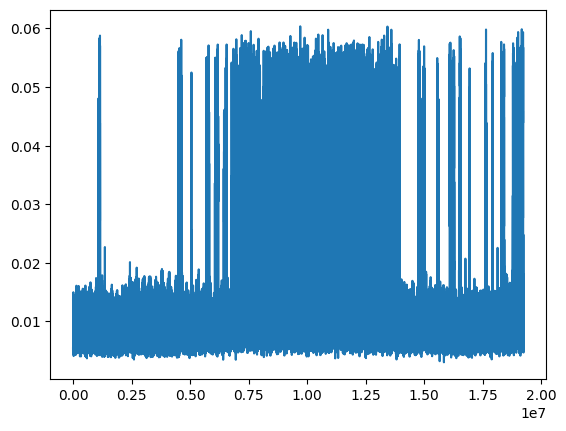

In [27]:
fig=plt.figure()
plt.plot(StdDevsZ)
plt.show()

In [22]:
StdDevsZ = np.nan_to_num(StdDevsZ)

StdDevsZ[StdDevsZ == np.inf] = 0
StdDevsZ[StdDevsZ == -np.inf] = 0

SmoothDevZ = denoise_wavelet(StdDevsZ, method='VisuShrink', mode='soft', wavelet='sym2', rescale_sigma='True')

print("denoise 1", ti()-start, np.shape(StdDevsZ))

denoise 1 467.4059443473816 (19255598,)


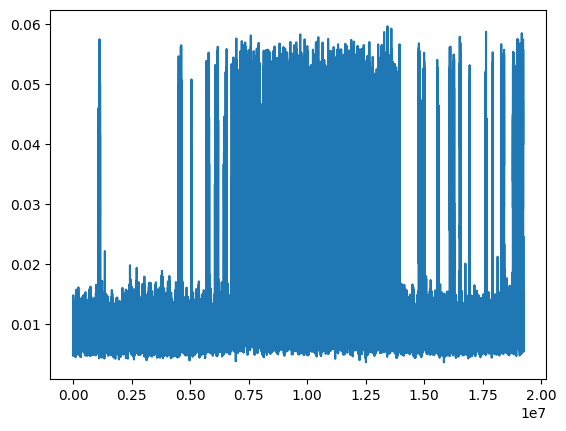

In [26]:
fig=plt.figure()
plt.plot(SmoothDevZ)
plt.show()

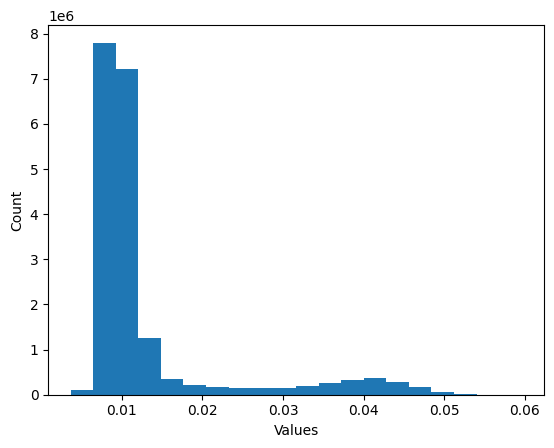

In [29]:
plt.hist(SmoothDevZ, bins=20)
plt.xlabel("Values")
plt.ylabel("Count")
plt.show()

In [28]:
SmoothDevZ[np.isnan(SmoothDevZ)]=0

Max = np.max(SmoothDevZ)

buckets = int(Max / 0.005) + 1
bins = np.linspace(0,buckets*0.005,buckets+1)
counts, bins = np.histogram(SmoothDevZ,bins=bins)

CummCount = 0
HalfWay = 0
for i in range(len(counts)):
    CummCount += counts[i]
    if CummCount / len(SmoothDevZ) >= 0.5:
        if HalfWay == 0:
            HalfWay = i

SquelchLevel = bins[HalfWay] 

print("SmoothDevz size", np.shape(SmoothDevZ),SquelchLevel)

SmoothDevz size (19255598,) 0.005


In [31]:
dataset["IsMoving"] = SquelchPattern(SmoothDevZ, 2000, 0.02, False)

print("Squelch Made", ti()-start)

Squelch Made 837.8748118877411


In [32]:
velocity = getVelocity(dataset.p, dataset.FracSec, dataset.IsMoving, 2)

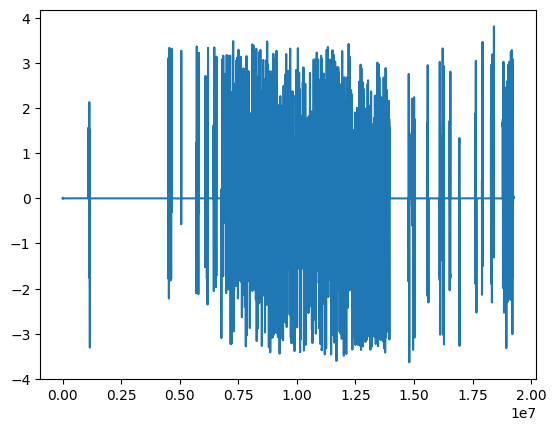

In [33]:
fig=plt.figure()
plt.plot(velocity)
plt.show()

In [ ]:
fig=plt.figure()
plt.plot(dataset.IsMoving)
plt.show()

In [34]:
df_pr = split_list_by_ones(dataset.p, dataset.IsMoving)
df_hr = split_list_by_ones(dataset.h, dataset.IsMoving)
df_vr = split_list_by_ones(dataset.v, dataset.IsMoving)

In [35]:
df_ps = split_list_by_zeros(dataset.SmoothP, dataset.IsMoving)
df_hs = split_list_by_zeros(dataset.SmoothH, dataset.IsMoving)
df_vs = split_list_by_zeros(dataset.SmoothV, dataset.IsMoving)

In [39]:
SmoothMove = []
for i in range(len(df_pr)):
    tempP=create_sequences(df_pr[i])
    tempH=create_sequences(df_hr[i])
    tempV=create_sequences(df_vr[i])
    for j in range(len(tempP)):
        SmoothMove.append(np.vstack((tempP[i],tempH[i],tempV[i]))) #,df_rs[i])))

SmoothStop = []
for i in range(len(df_ps)):
    tempP=create_sequences(df_ps[i])
    tempH=create_sequences(df_hs[i])
    tempV=create_sequences(df_vs[i])
    for j in range(len(tempP)):
        SmoothStop.append(np.vstack((tempP[i],tempH[i],tempV[i]))) #,df_rs[i])))


TypeError: object of type 'NoneType' has no len()

In [ ]:
len(SmoothMove)

In [ ]:
len(SmoothStop)